# The interplay between PVE and resampling  

In [1]:
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import nibabel 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import os.path as op 
from prepare_data import SIM_ROOT, REAL_ROOT, N_REPEATS
from helpers import load_basil, load_lr, load_oxasl, load_oxasl_lr
from scipy.ndimage import binary_erosion

Instructions for updating:
non-resource variables are not supported in the long term


## Simulated ASL 

To start with, we simulate ASL data using real brain anatomy and flat CBF in each tissue class. We add a low amount of white noise to the data as this is required to make FABBER operate in a realstic way. 

The ASL data is simulated with 5 PLDs of 8 repeats each (40 label-control pairs). Reference CBF and ATT values of 60 / 1.3, 20 / 1.6 are used for GM and WM respectively. 

In [2]:
mask = nibabel.load(str(SIM_ROOT / 'mask.nii.gz')).get_fdata().astype(np.bool)
pvs = nibabel.load(str(SIM_ROOT / 'tob_all_stacked_3.0.nii.gz')).get_fdata()[...,:2]
wmmask = (pvs[...,1] > 0.05)
gmmask = (pvs[...,0] > 0.05)

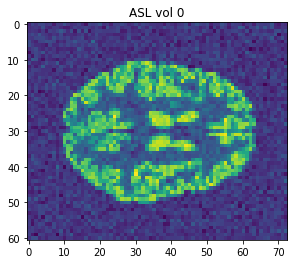

In [3]:
asl = nibabel.load(str(SIM_ROOT / 'asl_native.nii.gz')).get_fdata()
plt.imshow(asl[...,28,0])
plt.title('ASL vol 0')
plt.show()

## Resampling introduces PVE

Even without performing PVEc, resampling causes increased mixing of signal between tissue classes (ie, more PVE). This adds extra confound to the data. In order to demonstrate this, we generate a random affine transform, and then perform a round-trip on the data: 

Data -----> data forward transformed ------> data reverse transformed

After the round trip, we theoretically have recovered the original data and therefore the CBF analysis should give the same results. In practice, we have degraded the data by adding extra PVE and this is readily observed. 

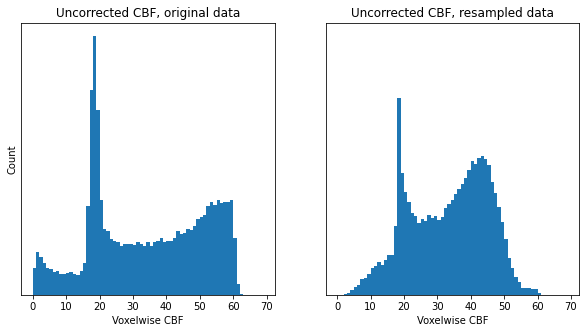

In [4]:
basil_native = load_basil(SIM_ROOT / 'basil_native', False)
basil_resamp = load_basil(SIM_ROOT / 'basil_double_resampled', False)

bins = np.arange(0,70,1)
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, data, title in zip(axes, [basil_native, basil_resamp], 
                           ['Uncorrected CBF, original data', 'Uncorrected CBF, resampled data']):
    ax.hist(data[mask], bins)
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
axes[0].set_ylabel('Count')
plt.show()

On the LHS we have the CBF from native data. Though there is clearly a lot of PVE, we can roughly see the underlying bimodal distribution of the ground truth CBF with peaks at 20 and 60 units. On the RHS, the resampled data shows the two peaks of the bimodal distribution have converged. The peak at 20 is significantly reduced; the peak at 60 has shifted to around 45. This is exactly the same result as would be obtained if the original data simply had higher PVE (ie, larger voxels). 

## Resampling and PVEc

Resampling increases PVE, and PVEc may not be able to fully correct for this. Continuing with the same schema above, of ASL data that has been through a round-trip of resampling, we now investigate PVEc of data that has been corrupted in this way. 

There are two strategies: 
1. PVEc with the original PVs (ie, the 'anatomical ground truth')
2. PVEc with PVs that have undergone the same processing as the data itself (ie, the 'double resampled')

Both FABBER and the linear regression operating on the ASL data (LR on data) are used. 

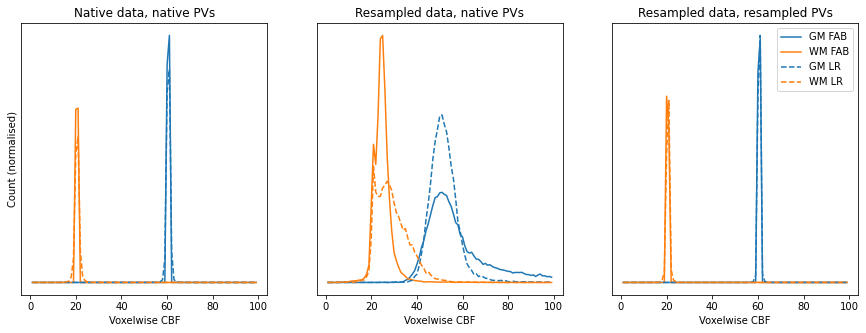

In [5]:
basil_native = load_basil(SIM_ROOT / 'basil_native')
basil_naive = load_basil(SIM_ROOT / 'basil_naive')
basil_resampled = load_basil(SIM_ROOT / 'basil_double_resampled')

lr_native = load_lr(SIM_ROOT / 'lr_native')
lr_naive = load_lr(SIM_ROOT / 'lr_naive')
lr_resampled = load_lr(SIM_ROOT / 'lr_double_resampled')

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=False)
bins = np.arange(0, 100, 1)

for ax, data, title in zip(axes, [basil_native, basil_naive, basil_resampled],
                        ['Native data, native PVs', 'Resampled data, native PVs', 'Resampled data, resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_native, lr_naive, lr_resampled]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

LHS: The native space data, before resampling, and PVEc with the native PVs. Ground truth is clearly recovered for both methods. 

Center: Resampled data, PVEc with the native PVs. Both methods struggle. FABBER does a better job on WM but suffers on GM (it gives a positive skewed distribution, ie, there is a long tail on the high side). LR does a better job on GM but struggles on WM (again, there is a positive skew with a long tail on the high side). 

RHS: Resampled data, PVEc with resampled PVs. Both methods are able to recover ground truth. 

There are two conclusions: 
1. analysis in native space is preferred from the point of view of PVEc. 
2. if resampling of data with PVE is required, then resampling the PV estimates in the same manner is a viable strategy (though as will be seen later, it doesn't always work perfectly). 

Does PVEc reduce inter-session variability in this context? Yes, although this is a highly artifical example constructed in such a way that reducing variability is the whole point. Will this apply on real data and between subjects? Its hard to say. One the one hand, we know that PVE will be different between subjects, especially for patients with a pathology that alters stucture (eg, AD), so we would hope PVEc helps there. On the other hand, some authors from the PET literature have found PVEc to actually increase inter-subject differences in a way that they think is meaningful, so I'm not sure theres a single answer to this question. 

## Common space analysis

The findings from the above experiment have practical implications for the analysis of repeat acquisition data. In particular, given a set of N un-registered acquisitions, each in their own native space, is it possible to perform voxel-wise analysis on a common template without falling foul of the resampling problem?

Because the subject may have moved slightly in between acquisitions, the distribution of PVEs within the data will be different on each. If we would like to remove this effect from the data then we will need to perform PVEc. Assuming we want to operate in the common space (eg, T1 ASL gridded space), whats the best way forwards?

The individual repeats are generated as follows:
1. generate a random transform and apply it to the common space PV estimates to get 'acquisition native PVs'
2. generate ASL data using these acquisition native PVs (with double the level of noise as before, to make things more realistic)
3. reverse transform the ASL data into common space to get the common aligned data (all will be co-registered)
4. reverse transform the acquisition native PVs to get 'double resampled' PVs. 
5. Estimate CBF on the common aligned data with two variants of PVEc: i) with the common space PV estimates ('naive') ii) with the double resampled PV estimates 

Step 5 is the slightly paradoxical bit: once all the data is in common alignment, in theory the only information required for PVEc of each repeat is the set of common space PV estimates. To be explicit, this involves correcting all the individual repeats using the same set of PV estimates. Given that we have applied the self-inverse of each transform, the repeats must all be in exactly the same alignment, and therefore there is only one anatomically correct set of PV estimates that could be used. In reality, we already know that the PVE in each native acquisition space were different to start with, so it follows that the PVE will still be different in the common aligned space. This is why the double-resampled PVs are useful: they convey information about the PVE that were present at the time the data was acquired, and this is what actually counts for successful PVEc. 

In [6]:
basil_naive = [] 
basil_dbl = []
lr_naive = [] 
lr_dbl = [] 

for idx in range(N_REPEATS): 
    basil_naive.append(load_basil(SIM_ROOT / f'basil_rpt{idx}_naive'))
    basil_dbl.append(load_basil(SIM_ROOT / f'basil_rpt{idx}_double_resampled'))
    lr_naive.append(load_lr(SIM_ROOT / f'lr_rpt{idx}_naive'))
    lr_dbl.append(load_lr(SIM_ROOT / f'lr_rpt{idx}_double_resampled'))
    
basil_naive = np.stack(basil_naive, axis=-1).mean(-1)
basil_dbl = np.stack(basil_dbl, axis=-1).mean(-1)
lr_naive = np.stack(lr_naive, axis=-1).mean(-1)
lr_dbl = np.stack(lr_dbl, axis=-1).mean(-1)

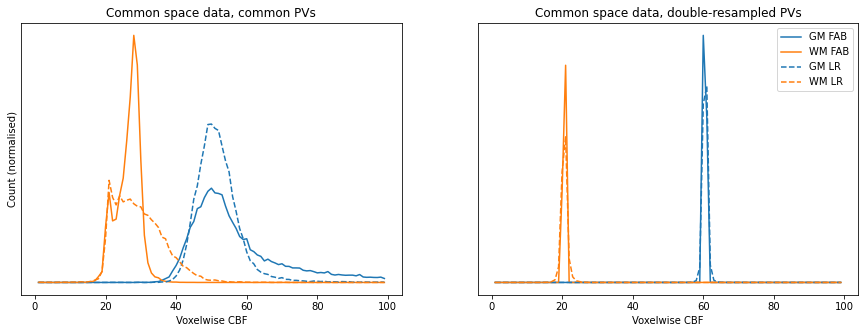

In [7]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=False)
bins = np.arange(0, 100, 1)

for ax, data, title in zip(axes, [basil_naive, basil_dbl],
                        ['Common space data, common PVs', 'Common space data, double-resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_naive, lr_dbl]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

LHS: PVEc using the common space PVs

RHS: PVEc using the double resampled PVs; both methods are able to recover ground truth. 

In both case, the mean distribution across 4 repeat acquisitions is shown. 

## Maastricht data 

The same set of experiments, this time performed using real data from Maastricht. 

The data is 200 volumes of single TI pASL at 3mm isotropic. There aren't any repeats so we can't do repeat analysis. There's only partial coverage of the brain so it doesn't pick up a huge amount of the cortex. The standard ATTs of 1.3 / 1.6s for GM / WM were used for analysis. 

In [8]:
mask = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_mask.nii.gz')).get_fdata()
gm = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_pvgm_tob.nii.gz')).get_fdata() 
wm = nibabel.load(str(REAL_ROOT / 'native/sub-SS_run-01_scale-2_space-native_pvgm_tob.nii.gz')).get_fdata() 

In [9]:
mask = binary_erosion(mask)
gmmask = (gm > 0.05) & mask
wmmask = (wm > 0.05) & mask

In [10]:
basil_native = load_oxasl(REAL_ROOT / 'native/basil_native', False)
basil_resamp = load_oxasl(REAL_ROOT / 'native/basil_resampled', False)
basil_double = load_oxasl(REAL_ROOT / 'native/basil_double')

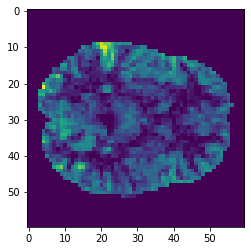

In [11]:
plt.imshow(basil_native[...,7])

## Resampling introduces PVE

Native space analysis, no PVEc, simply estimating CBF from data before / after resampling. 

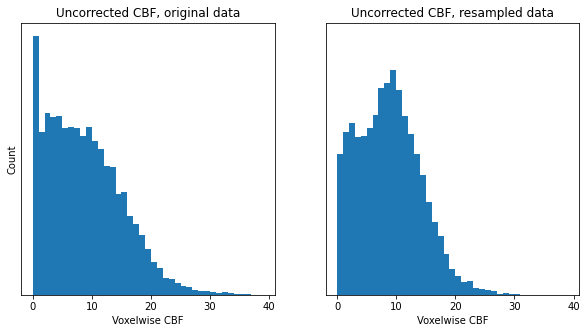

In [12]:
bins = np.arange(0,40,1)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
for ax, data, title in zip(axes, [basil_native, basil_resamp], 
                           ['Uncorrected CBF, original data', 'Uncorrected CBF, resampled data']):
    ax.hist(data[mask], bins)
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
axes[0].set_ylabel('Count')
plt.show()

The challenge of working with real data is immediately apparent: the distributions aren't even close to being bi-modal as they were in the simulation case. The fact that almost all voxels have less than 30 units of CBF shows the extent of PVE in the data (although this figure will of course be very sensitive to the choice of ATT used during analysis). At any rate, the extra PVE introduced by resampling is readily observed: the peak of the distribution shifts to around 10 units. 

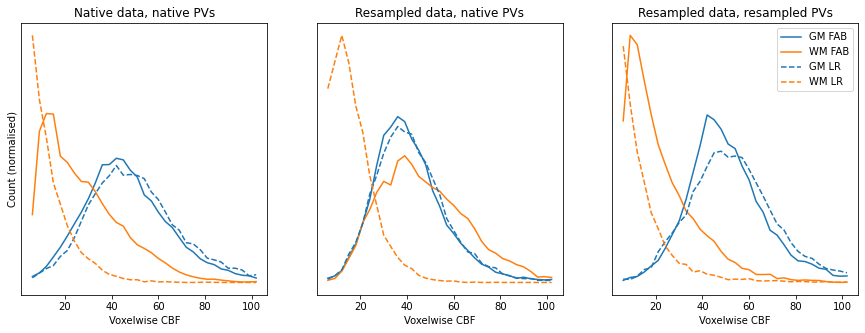

In [13]:
basil_native = load_oxasl(REAL_ROOT / 'native/basil_native')
basil_resamp = load_oxasl(REAL_ROOT / 'native/basil_resampled')
basil_double = load_oxasl(REAL_ROOT / 'native/basil_double')

lr_native = load_oxasl_lr(REAL_ROOT / 'native/lr_native')
lr_resamp = load_oxasl_lr(REAL_ROOT / 'native/lr_resampled')
lr_double = load_oxasl_lr(REAL_ROOT / 'native/lr_double')

fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=False)
bins = np.arange(3, 105, 3)

for ax, data, title in zip(axes, [basil_native, basil_resamp, basil_double],
                        ['Native data, native PVs', 'Resampled data, native PVs', 'Resampled data, resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_native, lr_resamp, lr_double]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()

In [14]:
mask = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_mask.nii.gz')).get_fdata()
gm = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_pvgm_tob.nii.gz')).get_fdata() 
wm = nibabel.load(str(REAL_ROOT / 'common/sub-SS_run-01_scale-2_space-common_pvgm_tob.nii.gz')).get_fdata() 

mask = binary_erosion(mask)
gmmask = (gm > 0.05) & mask
wmmask = (wm > 0.05) & mask

In [15]:
basil_naive = load_oxasl(REAL_ROOT / 'common/basil_naive')
basil_dbl = load_oxasl(REAL_ROOT / 'common/basil_double')
lr_naive = load_oxasl_lr(REAL_ROOT / 'common/lr_naive')
lr_dbl = load_oxasl_lr(REAL_ROOT / 'common/lr_double')

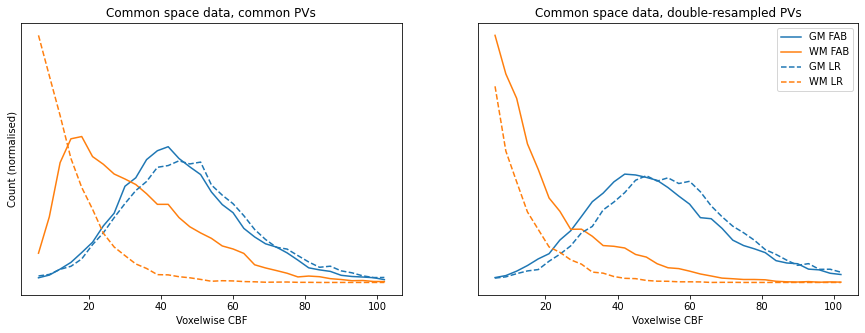

In [16]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=False)
bins = np.arange(3, 105, 3)

for ax, data, title in zip(axes, [basil_naive, basil_dbl],
                        ['Common space data, common PVs', 'Common space data, double-resampled PVs']):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:])
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:])
    ax.set_title(title)
    ax.set_xlabel('Voxelwise CBF')
    ax.set_yticks([])
    
for ax, data in zip(axes, [lr_naive, lr_dbl]):
    h, _ = np.histogram(data[gmmask,0], bins)
    ax.plot(bins[1:], h, c=cmap[0,:], linestyle='--')
    h, _ = np.histogram(data[wmmask,1], bins)
    ax.plot(bins[1:], h, c=cmap[1,:], linestyle='--')

axes[0].set_ylabel('Count (normalised)')
ax.legend(['GM FAB', 'WM FAB', 'GM LR', 'WM LR'])
plt.show()